# Session 9: Synthetic Data Generation and RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow, and use it to evaluate and iterate on a RAG pipeline with LangSmith!

**Learning Objectives:**
- Understand Ragas' knowledge graph-based synthetic data generation workflow
- Generate synthetic test sets with different query synthesizer types
- Load synthetic data into LangSmith for evaluation
- Evaluate a RAG chain using LangSmith evaluators
- Iterate on RAG pipeline parameters and measure the impact

## Table of Contents:

- **Breakout Room #1:** Synthetic Data Generation with Ragas
  - Task 1: Dependencies and API Keys
  - Task 2: Data Preparation and Knowledge Graph Construction
  - Task 3: Generating Synthetic Test Data
  - Question #1 & Question #2
  - 🏗️ Activity #1: Custom Query Distribution

- **Breakout Room #2:** RAG Evaluation with LangSmith
  - Task 4: LangSmith Dataset Setup
  - Task 5: Building a Basic RAG Chain
  - Task 6: Evaluating with LangSmith
  - Task 7: Modifying the Pipeline and Re-Evaluating
  - Question #3 & Question #4
  - 🏗️ Activity #2: Analyze Evaluation Results

---
# 🤝 Breakout Room #1
## Synthetic Data Generation with Ragas

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

### NLTK Import

To prevent errors that may occur based on OS - we'll import NLTK and download the needed packages to ensure correct handling of data.

In [1]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/yingzheli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yingzheli/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [3]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [3]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data using two complementary guides — a Health & Wellness Guide covering exercise, nutrition, sleep, and stress management, and a Mental Health & Psychology Handbook covering mental health conditions, therapeutic approaches, resilience, and daily mental health practices. The topical overlap between documents helps RAGAS build rich cross-document relationships in the knowledge graph.

Next, let's load our data into a familiar LangChain format using the `TextLoader`.

In [4]:
from langchain_community.document_loaders import DirectoryLoader, TextLoader

loader = DirectoryLoader("data/", glob="*.txt", loader_cls=TextLoader)
docs = loader.load()
print(f"Loaded {len(docs)} documents: {[d.metadata['source'] for d in docs]}")

Loaded 2 documents: ['data/MentalHealthGuide.txt', 'data/HealthWellnessGuide.txt']


### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [5]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

/Users/yingzheli/aimakerspace/AIE9/09_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/pysbd/segmenter.py:66: SyntaxWarning: invalid escape sequence '\s'
  for match in re.finditer('{0}\s*'.format(re.escape(sent)), self.original_text):
/Users/yingzheli/aimakerspace/AIE9/09_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/pysbd/lang/arabic.py:29: SyntaxWarning: invalid escape sequence '\.'
  txt = re.sub('(?<={0})\.'.format(am), '∯', txt)
/Users/yingzheli/aimakerspace/AIE9/09_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/pysbd/lang/persian.py:29: SyntaxWarning: invalid escape sequence '\.'
  txt = re.sub('(?<={0})\.'.format(am), '∯', txt)


Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [6]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [7]:
from ragas.testset.graph import Node, NodeType

for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 2, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [8]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/8 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/16 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 9, relationships: 16)

In [40]:
# See the list of transform steps
for i, t in enumerate(default_transforms):
    if hasattr(t, 'transformations'):  # Parallel group
        names = [x.__class__.__name__ for x in t.transformations]
        print(f"Step {i}: Parallel({', '.join(names)})")
    else:
        print(f"Step {i}: {t.__class__.__name__}")

Step 0: HeadlinesExtractor
Step 1: HeadlineSplitter
Step 2: SummaryExtractor
Step 3: CustomNodeFilter
Step 4: Parallel(EmbeddingExtractor, ThemesExtractor, NERExtractor)
Step 5: Parallel(CosineSimilarityBuilder, OverlapScoreBuilder)


In [45]:
for node in kg.nodes:
    if node.type.name == "DOCUMENT" and "headlines" in node.properties:
        print(f"Doc: {node.properties['page_content'][:80]}...")
        print(f"Headlines: {node.properties['headlines']}")
        print()

Doc: The Mental Health and Psychology Handbook
A Practical Guide to Understanding and...
Headlines: ['PART 1: FOUNDATIONS OF MENTAL HEALTH', 'Chapter 1: What Is Mental Health?', 'Chapter 2: Common Mental Health Conditions', 'Chapter 3: The Mind-Body Connection', 'PART 2: THERAPEUTIC APPROACHES']

Doc: The Personal Wellness Guide
A Comprehensive Resource for Health and Well-being

...
Headlines: ['PART 1: EXERCISE AND MOVEMENT', 'PART 2: NUTRITION AND DIET', 'PART 3: SLEEP AND RECOVERY', 'PART 4: STRESS MANAGEMENT AND MENTAL WELLNESS', 'PART 5: BUILDING HEALTHY HABITS']



In [41]:
# See relationships between nodes
for rel in kg.relationships:
    print(f"{rel.source.type} --[{rel.type}]--> {rel.target.type} | properties: {rel.properties}")


NodeType.DOCUMENT --[child]--> NodeType.CHUNK | properties: {}
NodeType.DOCUMENT --[child]--> NodeType.CHUNK | properties: {}
NodeType.DOCUMENT --[child]--> NodeType.CHUNK | properties: {}
NodeType.CHUNK --[next]--> NodeType.CHUNK | properties: {}
NodeType.DOCUMENT --[child]--> NodeType.CHUNK | properties: {}
NodeType.DOCUMENT --[child]--> NodeType.CHUNK | properties: {}
NodeType.DOCUMENT --[child]--> NodeType.CHUNK | properties: {}
NodeType.DOCUMENT --[child]--> NodeType.CHUNK | properties: {}
NodeType.CHUNK --[next]--> NodeType.CHUNK | properties: {}
NodeType.CHUNK --[next]--> NodeType.CHUNK | properties: {}
NodeType.CHUNK --[next]--> NodeType.CHUNK | properties: {}
NodeType.DOCUMENT --[cosine_similarity]--> NodeType.DOCUMENT | properties: {'summary_similarity': np.float64(0.8759243643747977)}
NodeType.CHUNK --[entities_overlap]--> NodeType.CHUNK | properties: {'entities_overlap_score': 0.01, 'overlapped_items': [('CBT', 'CBT-I')]}
NodeType.CHUNK --[entities_overlap]--> NodeType.CHUN

In [44]:
# Show which document each chunk belongs to
for rel in kg.relationships:
    if rel.type == "child":
        doc_content = rel.source.properties["page_content"][:80]
        chunk_content = rel.target.properties["page_content"][:80]
        print(f"Doc: {doc_content}...")
        print(f"  └─ Chunk: {chunk_content}...")
        print()

# Show entity overlap edges with actual chunk content
for rel in kg.relationships:
    if rel.type == "entities_overlap":
        src = rel.source.properties["page_content"][:80]
        tgt = rel.target.properties["page_content"][:80]
        score = rel.properties["entities_overlap_score"]
        print(f"Source type: {rel.source.type}")
        print(f"Target type: {rel.target.type}")
        print(f"Source content length: {len(rel.source.properties['page_content'])}")
        print(f"Score: {score:.2f}")
        print(f"  From: {src}...")
        print(f"  To:   {tgt}...")
        print()

Doc: The Mental Health and Psychology Handbook
A Practical Guide to Understanding and...
  └─ Chunk: The Mental Health and Psychology Handbook A Practical Guide to Understanding and...

Doc: The Mental Health and Psychology Handbook
A Practical Guide to Understanding and...
  └─ Chunk: PART 2: THERAPEUTIC APPROACHES Chapter 4: Cognitive Behavioral Therapy (CBT) Cog...

Doc: The Mental Health and Psychology Handbook
A Practical Guide to Understanding and...
  └─ Chunk: social interactions How to set and maintain boundaries: - Identify your limits a...

Doc: The Personal Wellness Guide
A Comprehensive Resource for Health and Well-being

...
  └─ Chunk: The Personal Wellness Guide A Comprehensive Resource for Health and Well-being P...

Doc: The Personal Wellness Guide
A Comprehensive Resource for Health and Well-being

...
  └─ Chunk: PART 3: SLEEP AND RECOVERY Chapter 7: The Science of Sleep Sleep is crucial for ...

Doc: The Personal Wellness Guide
A Comprehensive Resource for Health a

```
  [DOCUMENT 1] ----cosine_similarity (0.88)---- [DOCUMENT 2]
    │  │  │                                      │  │  │  │
  child child child                           child child child child
    ↓    ↓    ↓                                  ↓    ↓    ↓    ↓
  [C1]→[C2]→[C3]                              [C4]→[C5]→[C6]→[C7]
    │              entities_overlap               │
    └──────────────────────────────────────────────┘
              (+ various chunk-to-chunk entity overlap edges)
```

In [42]:
# Check what properties were added to each node
for i, node in enumerate(kg.nodes):
    print(f"\nNode {i} ({node.type}): {list(node.properties.keys())}")

# See summaries (DOCUMENT nodes)
for node in kg.nodes:
    if node.type.name == "DOCUMENT" and "summary" in node.properties:
        print(f"Summary: {node.properties['summary'][:300]}")

# See NER entities (CHUNK nodes)
for node in kg.nodes:
    if node.type.name == "CHUNK" and "entities" in node.properties:
        print(f"Entities: {node.properties['entities']}")

# See themes (CHUNK nodes)
for node in kg.nodes:
    if node.type.name == "CHUNK" and "themes" in node.properties:
        print(f"Themes: {node.properties['themes']}")



Node 0 (NodeType.DOCUMENT): ['page_content', 'document_metadata', 'headlines', 'summary', 'summary_embedding']

Node 1 (NodeType.DOCUMENT): ['page_content', 'document_metadata', 'headlines', 'summary', 'summary_embedding']

Node 2 (NodeType.CHUNK): ['page_content', 'entities', 'themes']

Node 3 (NodeType.CHUNK): ['page_content', 'entities', 'themes']

Node 4 (NodeType.CHUNK): ['page_content', 'entities', 'themes']

Node 5 (NodeType.CHUNK): ['page_content', 'entities', 'themes']

Node 6 (NodeType.CHUNK): ['page_content', 'entities', 'themes']

Node 7 (NodeType.CHUNK): ['page_content', 'entities', 'themes']

Node 8 (NodeType.CHUNK): ['page_content', 'entities', 'themes']
Summary: The handbook explains that mental health involves emotional, psychological, and social well-being, influenced by biological, experiential, and environmental factors. It details common conditions like anxiety, depression, and PTSD, highlighting their symptoms and impacts. The importance of the mind-b
Summary: Th

We can save and load our knowledge graphs as follows.

In [9]:
kg.save("usecase_data_kg.json")
usecase_data_kg = KnowledgeGraph.load("usecase_data_kg.json")
usecase_data_kg

KnowledgeGraph(nodes: 9, relationships: 16)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [10]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=usecase_data_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [11]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

## ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.

##### Answer:

- SingleHopSpecificQuerySynthesizer: generate factual questions from a chunk or a document, which will target a specific named entity.
- MultiHopSpecificQuerySynthesizer: generate factual questions that require two chunks that share named entities, which will target facts about the shared entity across both contexts. 
- MultiHopAbstractQuerySynthesizer: generate conceptual or comparative questions from child chunks of multiple documents that are semantically similar, which will target abstract questions using the themes of those child chunks. 

Finally, we can use our `TestSetGenerator` to generate our testset!

In [12]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,How does the World Health Organization define ...,[The Mental Health and Psychology Handbook A P...,"According to the context, the World Health Org...",single_hop_specifc_query_synthesizer
1,Is the University of Massachusetts Medical Cen...,[PART 2: THERAPEUTIC APPROACHES Chapter 4: Cog...,"Yes, the University of Massachusetts Medical C...",single_hop_specifc_query_synthesizer
2,How does social media impact mental health and...,[social interactions How to set and maintain b...,Social media can affect mental health by lower...,single_hop_specifc_query_synthesizer
3,Chapter 4 what is it,[The Personal Wellness Guide A Comprehensive R...,Chapter 4 discusses the fundamentals of health...,single_hop_specifc_query_synthesizer
4,What is REM in sleep?,[PART 3: SLEEP AND RECOVERY Chapter 7: The Sci...,REM Sleep is a stage where the brain is active...,single_hop_specifc_query_synthesizer
5,how create good sleep enviroment and emotional...,[<1-hop>\n\nPART 2: THERAPEUTIC APPROACHES Cha...,Creating an optimal sleep environment involves...,multi_hop_abstract_query_synthesizer
6,How does sleep quality influence mental health...,[<1-hop>\n\nThe Mental Health and Psychology H...,Sleep quality plays a crucial role in both men...,multi_hop_abstract_query_synthesizer
7,how to support immune function and eat healthy...,[<1-hop>\n\nPART 5: BUILDING HEALTHY HABITS Ch...,to support immune function and eat healthy die...,multi_hop_abstract_query_synthesizer
8,How can understanding the detailed sleep cycle...,[<1-hop>\n\nPART 3: SLEEP AND RECOVERY Chapter...,Understanding the detailed sleep cycles and sl...,multi_hop_specific_query_synthesizer
9,How can Cognitive Behavioral Therapy (CBT) and...,[<1-hop>\n\nPART 3: SLEEP AND RECOVERY Chapter...,Integrating Cognitive Behavioral Therapy (CBT)...,multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [50]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/8 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/18 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [51]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,Wht is the World Health Organization?,[The Mental Health and Psychology Handbook A P...,"According to the context, the World Health Org...",single_hop_specifc_query_synthesizer
1,What is Mindfulness-Based Cognitive Therapy?,[PART 2: THERAPEUTIC APPROACHES Chapter 4: Cog...,Mindfulness-Based Cognitive Therapy (MBCT) com...,single_hop_specifc_query_synthesizer
2,As a wellness coach focused on holistic health...,[Write letters to or from your future self Jou...,Exercise affects the brain in multiple benefic...,single_hop_specifc_query_synthesizer
3,What are some effective mental health resource...,[social interactions How to set and maintain b...,The context provides information about managin...,single_hop_specifc_query_synthesizer
4,How can supportiv relationships and social int...,[<1-hop>\n\nPART 2: THERAPEUTIC APPROACHES Cha...,Supportiv relationships are crucial for buildi...,multi_hop_abstract_query_synthesizer
5,how can stress reduction techniques like deep ...,[<1-hop>\n\nPART 3: SLEEP AND RECOVERY Chapter...,Stress reduction techniques such as deep breat...,multi_hop_abstract_query_synthesizer
6,How do exercise benefits and stress impact inf...,[<1-hop>\n\nThe Personal Wellness Guide A Comp...,The context explains that regular exercise imp...,multi_hop_abstract_query_synthesizer
7,what signs shoud i look for to see if i need p...,[<1-hop>\n\nPART 2: THERAPEUTIC APPROACHES Cha...,The context indicates that signs indicating th...,multi_hop_abstract_query_synthesizer
8,how CBT and CBT-I help mental health and self-...,[<1-hop>\n\nPART 2: THERAPEUTIC APPROACHES Cha...,The context explains that CBT (Cognitive Behav...,multi_hop_specific_query_synthesizer
9,How can understanding the science of habit for...,[<1-hop>\n\nPART 5: BUILDING HEALTHY HABITS Ch...,Understanding the science of habit formation i...,multi_hop_specific_query_synthesizer


In [53]:
for i, q in enumerate(dataset.to_pandas()['user_input']):
    print(f"{i}: {q}")

0: Wht is the World Health Organization?
1: What is Mindfulness-Based Cognitive Therapy?
2: As a wellness coach focused on holistic health practices, how does exercise contribute to mental health, and what are some recommended ways to incorporate exercise into a routine to maximize its benefits for mental well-being?
3: What are some effective mental health resources and strategies I can access or implement to support my mental well-being in the digital age?
4: How can supportiv relationships and social interactions and boundary-setting help improve mental health and resilience, especially when practicing mindfulness and managing digital mental health?
5: how can stress reduction techniques like deep breathing and grounding help improve sleep quality and overall mental wellness according to the sleep and stress chapters, especially when combined with good sleep hygiene practices and mindfulness?
6: How do exercise benefits and stress impact influence overall health and sleep quality?
7

## ❓ Question #2:

Ragas offers both an "unrolled" (manual) approach and an "abstracted" (automatic) approach to synthetic data generation. What are the trade-offs between these two approaches? When would you choose one over the other?

##### Answer:


Unrolled (manual) approach will let us build the knowledge graph and run the transforms  from scratch before calling generate. This enables us to inspect the knowledge graph (e.g., the node and edges) at each step to check the details of the graph or debug; also we can build a custom transform based on our use case instead of the default transform. We can also save the knowledge for re-use. Downside is manual approach requires extra efforts to implement.

Abstract (automated) approach uses one call (e.g., `generate_with_langchain_docs`) to do everything, including building the knowledge graph, runs default transform, and generates the testset. It's simple to write and when default transform works great.

Choose unrolled when we need to customize the transform pipeline or debug the knowledge graph or re-use the knowledge graph. 
Choose abstracted when we need to quickly generate testset and the default transform works fine for our use case.

---
## 🏗️ Activity #1: Custom Query Distribution

Modify the `query_distribution` to experiment with different ratios of query types.

### Requirements:
1. Create a custom query distribution with different weights than the default
2. Generate a new test set using your custom distribution
3. Compare the types of questions generated with the default distribution
4. Explain why you chose the weights you did

In [54]:
### YOUR CODE HERE ###

# Define a custom query distribution with different weights
# Generate a new test set and compare with the default

# 1. New query distribution
query_distribution = [
    (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.7),
    (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.15),
    (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.15),
]

# 2. Generate test set
testset = generator.generate(testset_size=20, query_distribution=query_distribution)
testset.to_pandas()


Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/20 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,What information does the Psychology Handbook ...,[The Mental Health and Psychology Handbook A P...,The Psychology Handbook describes mental healt...,single_hop_specifc_query_synthesizer
1,Wht is the United States's role in mental heal...,[The Mental Health and Psychology Handbook A P...,The context provided does not specify the role...,single_hop_specifc_query_synthesizer
2,What is MBCT and how does it help with mental ...,[PART 2: THERAPEUTIC APPROACHES Chapter 4: Cog...,"MBCT, or Mindfulness-Based Cognitive Therapy, ...",single_hop_specifc_query_synthesizer
3,What is Mindfulness-Based Stress Reduction?,[PART 2: THERAPEUTIC APPROACHES Chapter 4: Cog...,Mindfulness-Based Stress Reduction (MBSR) is a...,single_hop_specifc_query_synthesizer
4,How does exercise impact mental health accordi...,[Write letters to or from your future self Jou...,Exercise affects the brain in multiple benefic...,single_hop_specifc_query_synthesizer
5,How does sleep impact mental health according ...,[Write letters to or from your future self Jou...,Sleep and mental health have a bidirectional r...,single_hop_specifc_query_synthesizer
6,What are the key points discussed in Chapter 1...,[social interactions How to set and maintain b...,Chapter 16 addresses managing digital mental h...,single_hop_specifc_query_synthesizer
7,What are some effective mental health resource...,[social interactions How to set and maintain b...,The context mentions various mental health res...,single_hop_specifc_query_synthesizer
8,What are the most effective exercises recommen...,[The Personal Wellness Guide A Comprehensive R...,The Personal Wellness Guide recommends gentle ...,single_hop_specifc_query_synthesizer
9,How do vitamins contribute to overall health a...,[The Personal Wellness Guide A Comprehensive R...,Vitamins are organic compounds needed in small...,single_hop_specifc_query_synthesizer


In [55]:
for i, q in enumerate(testset.to_pandas()['user_input']):
    print(f"{i}: {q}")

0: What information does the Psychology Handbook provide about mental health and its connection to overall well-being?
1: Wht is the United States's role in mental health awareness?
2: What is MBCT and how does it help with mental health?
3: What is Mindfulness-Based Stress Reduction?
4: How does exercise impact mental health according to your guidance?
5: How does sleep impact mental health according to your guidance?
6: What are the key points discussed in Chapter 16 regarding managing digital mental health and setting boundaries to support overall well-being?
7: What are some effective mental health resources I can access online?
8: What are the most effective exercises recommended for relief from back pain according to the Personal Wellness Guide, and how do they help alleviate discomfort?
9: How do vitamins contribute to overall health and wellness according to the Personal Wellness Guide?
10: What information is covered in Chapter 9 regarding sleep and recovery?
11: Could you ple

### 3. Compare the types of questions generated with the default distribution

The custom distribution I used follows 70/15/15 split, while the default distrubtion in the abstracted SDG is following an even split bewteen the 3 types of user inputs.

Based on the generated questions, question 0 to 13 are single hop factual questions targeting a single chunk; while question 14 to 19 are multi-hop questions that cross reference multiple chunks. 

This custom distrubtion creates more simple factual question compared to a more evenly distrubted question set from the default distribution.

Also I have generated 20 total questions in the custom distrubtion.


### 4. Explain why you chose the weights you did
I used a 70/15/15 split under the assumption that we will build a wellness chatbot where most users of our system will ask simple direct health questions that can be answered using a single source from our data sources. These quick questions will account for 70% of our queries.

The remaining 30% queries are for more complex questions that need to reference multiple chunks of our documents, thus requiring multi-hop questions. 



We'll need to provide our LangSmith API key, and set tracing to "true".

---
# 🤝 Breakout Room #2
## RAG Evaluation with LangSmith

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [15]:
from langsmith import Client
import uuid

client = Client()

dataset_name = f"Use Case Synthetic Data - AIE9 - {uuid.uuid4()}"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Synthetic Data for Use Cases"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [16]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [17]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [18]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [19]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [20]:
from langchain_qdrant import QdrantVectorStore

vectorstore = QdrantVectorStore.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="use_case_rag"
)

In [21]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [22]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

As is usual: We'll be using `gpt-4.1-mini` for our RAG!

In [23]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini")

Finally, we can set-up our RAG LCEL chain!

In [24]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain_core.output_parsers import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [25]:
rag_chain.invoke({"question" : "What are some recommended exercises for lower back pain?"})

'Recommended exercises for lower back pain include:\n\n- Cat-Cow Stretch: Start on hands and knees, alternate between arching your back up (cat) and letting it sag down (cow). Do 10-15 repetitions.\n- Bird Dog: From hands and knees, extend opposite arm and leg while keeping your core engaged. Hold for 5 seconds, then switch sides. Do 10 repetitions per side.\n- Partial Crunches: Lie on your back with knees bent, cross arms over chest, tighten stomach muscles and raise shoulders off floor. Hold briefly, then lower. Do 8-12 repetitions.\n- Knee-to-Chest Stretch: Lie on your back, pull one knee toward your chest while keeping the other foot flat. Hold for 15-30 seconds, then switch legs.\n- Pelvic Tilts: Lie on your back with knees bent, flatten your back against the floor by tightening abs and tilting pelvis up slightly. Hold for 10 seconds, repeat 8-12 times.'

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4.1 as our evaluation LLM for our base Evaluators.

In [26]:
eval_llm = ChatOpenAI(model="gpt-4.1")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [27]:
from openevals.llm import create_llm_as_judge
from langsmith.evaluation import evaluate

# 1. QA Correctness (replaces LangChainStringEvaluator("qa"))
qa_evaluator = create_llm_as_judge(
    prompt="You are evaluating a QA system. Given the input, assess whether the prediction is correct.\n\nInput: {inputs}\nPrediction: {outputs}\nReference answer: {reference_outputs}\n\nIs the prediction correct? Return 1 if correct, 0 if incorrect.",
    feedback_key="qa",
    model="openai:gpt-4o" ,  # pass your LangChain chat model directly
)

# 2. Labeled Helpfulness (replaces LangChainStringEvaluator("labeled_criteria"))
labeled_helpfulness_evaluator = create_llm_as_judge(
    prompt=(
        "You are assessing a submission based on the following criterion:\n\n"
        "helpfulness: Is this submission helpful to the user, "
        "taking into account the correct reference answer?\n\n"
        "Input: {inputs}\n"
        "Submission: {outputs}\n"
        "Reference answer: {reference_outputs}\n\n"
        "Does the submission meet the criterion? Return 1 if yes, 0 if no."
    ),
    feedback_key="helpfulness",
    model="openai:gpt-4o" ,
)

# 3. Dopeness (replaces LangChainStringEvaluator("criteria"))
dopeness_evaluator = create_llm_as_judge(
    prompt=(
        "You are assessing a submission based on the following criterion:\n\n"
        "dopeness: Is this response dope, lit, cool, or is it just a generic response?\n\n"
        "Input: {inputs}\n"
        "Submission: {outputs}\n\n"
        "Does the submission meet the criterion? Return 1 if yes, 0 if no."
    ),
    feedback_key="dopeness",
    model="openai:gpt-4o" ,
)

> **Describe what each evaluator is evaluating:**
>
> - `qa_evaluator`:
> - `labeled_helpfulness_evaluator`:
> - `dopeness_evaluator`:

## LangSmith Evaluation

In [28]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dopeness_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'respectful-ray-57' at:
https://smith.langchain.com/o/991456bb-c3e2-422e-957d-4e5bfe176b65/datasets/55ccc086-1206-4d3c-9fb7-a20fd254acd3/compare?selectedSessions=073233c3-22d5-4fa9-be02-72e8d6a4eb47




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.qa,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,how vitamin D and vitamins help mental health ...,Based on the provided context:\n\n- Vitamin D ...,None,The context explains that vitamins are organic...,False,True,False,3.606122,90d483e3-c566-4e76-9517-5cf23001ef9b,019c4a59-605e-75e2-b212-7a70542df24a
1,how to set boundaries and manage digital menta...,To set boundaries and manage digital mental he...,None,"to set boundaries, identify your limits, commu...",True,True,False,4.888614,b20d8404-a7b5-48e2-9001-a41672730f34,019c4a59-98bf-7fb1-a74f-8d249202510f
2,How can understanding CBT and CBT-I enhance em...,Understanding CBT (Cognitive Behavioral Therap...,None,Understanding Cognitive Behavioral Therapy (CB...,True,True,False,5.217875,9cd16c12-ee0a-4586-baa1-463e29f832af,019c4a59-d7a6-7522-aa7e-b96642910558
3,How does understanding the fundamentals of hea...,I don't know.,None,Understanding the fundamentals of healthy eati...,False,False,False,0.694346,48a15c8b-4388-4f58-aa6f-0ff41cdf3967,019c4a5a-342a-7fa3-b3b1-36f4e747fdfc
4,How does the menta health and well-being relat...,"Based on the provided context, mental health i...",None,The menta health and well-being encompass emot...,True,True,False,5.168238,6b7a96b7-e1f8-4940-a51e-43708b5dd741,019c4a5a-539e-74b2-a5e0-143a2fdd1b30
5,How do social comparison and cyberbullying aff...,Based on the context provided:\n\nSocial compa...,None,Social comparison can lower self-esteem and li...,True,True,True,3.908022,27c73d31-1bd9-4de1-a827-9172a476f047,019c4a5a-9ec1-7651-bf19-29d38ca23b01
6,H0w can driking enough water help building hea...,Drinking enough water supports building health...,None,Driking enough water is essential for maintain...,True,True,False,3.748901,51832c42-e4fe-4497-bb29-c1d3e41b2666,019c4a5a-cd2d-7af2-8529-f13af1a5b356
7,What strategies can help manage digital mental...,Strategies to manage digital mental health cha...,None,To manage digital mental health challenges and...,True,True,False,3.441254,2d951711-0956-404c-93aa-4231b10dbf55,019c4a5b-1013-7911-a2d2-5342dcfb81a3
8,How can managing digital mental health help im...,Managing digital mental health can help improv...,None,Managing digital mental health involves settin...,True,True,False,2.785712,d1f0b138-255c-4186-b5f0-836185223e65,019c4a5b-5e11-7712-bcdc-491956a40c03
9,What role does zinc play in mental health acco...,"According to the context, zinc is linked to me...",None,"Zinc is a nutrient found in oysters, beef, and...",True,True,False,1.393995,756a65f6-25f5-4fd1-b816-a519e907e29b,019c4a5b-9cba-7883-b706-8039907f4e8c


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [29]:
DOPENESS_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Make your answer rad, ensure high levels of dopeness. Do not be generic, or give generic responses.

Context: {context}
Question: {question}
"""

dopeness_rag_prompt = ChatPromptTemplate.from_template(DOPENESS_RAG_PROMPT)

In [30]:
rag_documents = docs

In [31]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

## ❓ Question #3:

Why would modifying our chunk size modify the performance of our application?

##### Answer:
For the dopness RAG, we have increased the `chunk_size` to `1000` from `500`. As a result, for the dopness RAG, each retrieved chunk will contain more information and context compared to the chunks (of size `500`) retrieved in the first RAG chain. In general, a smaller chunk size means each retrieved chunk contains more precise context but may also lack enough surrounding context; while a larger chunk means each chunk contains more context but at the same time could also contain more irrelevant context.

Since our goal for the dopness RAG is to make answers more rad and higher level of dopeness, LLM will need more context to create a richer and non-generic answer. Larger chunks could give more complete sentences and paragraphs compared to the smaller chunks, which could help LLM generate more coherent and dope answers. 


In [32]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

## ❓ Question #4:

Why would modifying our embedding model modify the performance of our application?

##### Answer:
We have switched from `text-embedding-3-small` in the first chain to `text-embedding-3-large` in the dopeness RAG chain.

Having a larger embedding model makes the vector representation of each chunk to have a higher dimension, which can capture more semantic nuances and topics among the text. This goes together with previous question as well, since now each chunk size has increased to 1000 from 500, using a larger embedding model will help capture the additional semantic nuances from a larger chunk.

In addition, using a larger embedding model will improve the retrival quality as well. This is because since embedding captures more semantic meanings and nuances, the retriever is more likely to retrieve relevant chunks for a given question, and more relevant context can lead to better answers from the LLM. 

In [33]:
from langchain_qdrant import QdrantVectorStore

vectorstore = QdrantVectorStore.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="Use Case RAG Docs"
)

In [34]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [35]:
dopeness_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dopeness_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [36]:
dopeness_rag_chain.invoke({"question" : "How can I improve my sleep quality?"})

"Yo, ready to upgrade your sleep game to absolute legend status? Here’s the prime blueprint straight from the sleep gurus in the guide:\n\n**1. Lock in a Consistent Sleep Schedule:** Don’t mess with your body’s internal DJ – keep lights out and rise-up time steady, even on weekends. Your circadian rhythm will thank you big time.\n\n**2. Master the Pre-Sleep Ritual:** Wind down like a pro—think reading a chill book, gentle stretching, or soaking in a warm bath. This signals your brain it’s go-time for dreamland.\n\n**3. Optimize Your Sleep Cave:** Keep your bedroom a cryo-chamber of coolness—aim for 65-68°F (18-20°C). Block out light ninja-style with blackout curtains or a sleep mask, and drop silence bombs using white noise machines or earplugs. Don’t settle—invest in a mattress and pillows that cradles you like a cloud.\n\n**4. Screen Detox Before Bed:** Shut down all screens 1-2 hours prior to lights-out. That blue light is a sleep assassin, killing your melatonin vibes.\n\n**5. Caff

Finally, we can evaluate the new chain on the same test set!

In [37]:
evaluate(
    dopeness_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dopeness_evaluator
    ],
    metadata={"revision_id": "dopeness_rag_chain"},
)

View the evaluation results for experiment: 'ordinary-unit-25' at:
https://smith.langchain.com/o/991456bb-c3e2-422e-957d-4e5bfe176b65/datasets/55ccc086-1206-4d3c-9fb7-a20fd254acd3/compare?selectedSessions=006ddcc3-3d36-4555-bf13-4cd2707e9d80




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.qa,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,how vitamin D and vitamins help mental health ...,"Oh heck yeah, let’s dive into this vitamin vib...",None,The context explains that vitamins are organic...,True,True,True,6.157861,90d483e3-c566-4e76-9517-5cf23001ef9b,019c4a5f-028a-7c41-aba1-caf496290000
1,how to set boundaries and manage digital menta...,Yo! Ready to level up your mental game and own...,None,"to set boundaries, identify your limits, commu...",True,True,True,7.580373,b20d8404-a7b5-48e2-9001-a41672730f34,019c4a5f-3e0e-7dc0-9c8e-235dc53d109d
2,How can understanding CBT and CBT-I enhance em...,"Alright, strap in for some next-level brain vi...",None,Understanding Cognitive Behavioral Therapy (CB...,True,True,True,5.548836,9cd16c12-ee0a-4586-baa1-463e29f832af,019c4a5f-9154-78d2-9b88-3a2be4d655e1
3,How does understanding the fundamentals of hea...,"Yo, let's connect the dots and level up your w...",None,Understanding the fundamentals of healthy eati...,True,True,True,6.398523,48a15c8b-4388-4f58-aa6f-0ff41cdf3967,019c4a5f-e12a-7bb1-8c4d-a387a00028ea
4,How does the menta health and well-being relat...,"Alright, let’s dial up the dopest synergy betw...",None,The menta health and well-being encompass emot...,True,True,True,5.336413,6b7a96b7-e1f8-4940-a51e-43708b5dd741,019c4a60-3620-72c3-b4b7-e432110ae49d
5,How do social comparison and cyberbullying aff...,"Alright, here’s the scoop straight from the me...",None,Social comparison can lower self-esteem and li...,True,True,True,5.426658,27c73d31-1bd9-4de1-a827-9172a476f047,019c4a60-7fe0-7711-ad06-2d866f3f5bd5
6,H0w can driking enough water help building hea...,"Yo, here’s the lowdown on how guzzling that ag...",None,Driking enough water is essential for maintain...,True,True,True,6.459953,51832c42-e4fe-4497-bb29-c1d3e41b2666,019c4a60-b5ce-7662-acec-b4ca756d9848
7,What strategies can help manage digital mental...,"Alright, let’s crank up the digital wellness v...",None,To manage digital mental health challenges and...,True,True,True,7.434309,2d951711-0956-404c-93aa-4231b10dbf55,019c4a61-0988-7163-8f9c-b0cf69b24eec
8,How can managing digital mental health help im...,"Yo, managing digital mental health is like dro...",None,Managing digital mental health involves settin...,True,True,True,3.351323,d1f0b138-255c-4186-b5f0-836185223e65,019c4a61-473b-75d2-ab57-96e2d1467e30
9,What role does zinc play in mental health acco...,Zinc is straight-up a brain booster in the men...,None,"Zinc is a nutrient found in oysters, beef, and...",True,True,True,2.410045,756a65f6-25f5-4fd1-b816-a519e907e29b,019c4a61-7aca-7213-bc3a-76836c3387a5


---
## 🏗️ Activity #2: Analyze Evaluation Results

Provide a screenshot of the difference between the two chains in LangSmith, and explain why you believe certain metrics changed in certain ways.

##### Answer:
![Comparison of rag_chain vs dopeness_rag_chain](comparison.png)

The names in the screenshot are as follow: 
- `respectful-ray-57` --> `rag_chain`
- `ordinary-unit-25` --> `dopeness_rag_chain`

Here are some observed differences and explanations:

1. dopeness_rag_chain has perfect eval score in all the aspects (dopeness, helpfulness, qa), all of which are higher than the rag_chain. 

- First of all, the higher score across all the dimensions benefit from using a larger chunk (which provides richer context for each retrieved chunk), and using a larger embedding model (which retrieves more relevant context for each query). Although rag_chain has a decent helpfulness and qa score (0.92, and 0.83), these improvements in dopeness_rag_chain increased the score to a perfect 1.0. 

- Dopeness score has seen the biggest increase from only 0.08 to 1.00, and this is greatly benefited from the additional instructions in our system prompt for dopeness rag: `Make your answer rad, ensure high levels of dopeness. Do not be generic, or give generic responses.` This instruction should also have benefited the other two scores as well, but it has the biggest impact for dopeness.

2. For latency, `dopeness_rag_chain` has about 40% higher P50/P99 latency compared to `rag_chain`. One source of the increased latency is that embedding user query is slower for `dopeness_rag_chain` since the embedding model is larger. The retrieval process in general should be very fast, so even though `rag_chain` needs to retrieve 10 chunks (of size 500) while `dopeness_rag_chain` needs to only retrieve 4 chunks (of size 1000), one source of latency increase comes from embedding user query. In addition, since the dopeness_rag_chain is instructed to produce non-generic dope answers, the LLM will spend longer time to generate more output tokens, this is likely the biggest source of latency increase. More details on output tokens in the next part.

3. For tokens, the `rag_chain` has a higher input token and lower output token compared to `dopeness_rag_chain`. 

- For input token, `rag_chain` is higher since the retrieval process needs to retrieve 10 chunks of 500 each; while `dopeness_rag_chain` needs to retrieve only 4 chunks of 1000 each; so total input is higher for `rag_chain`.

- For output token, since each retrieved chunk of `dopeness_rag_chain` has larger size, and that the system prompt for `dopeness_rag_chain` instructs it to create specific, dope, non-generic answers, this leads to more comprehensive answers, and hence higher output token.

4. For cost, it follows same trend as tokens, where `dopeness_rag_chain` has lower input token cost, higher output cost, and higher total cost than `rag_chain`.

---
## Summary

In this session, we:

1. **Generated synthetic test data** using Ragas' knowledge graph-based approach
2. **Explored query synthesizers** for creating diverse question types
3. **Loaded synthetic data** into a LangSmith dataset for evaluation
4. **Built and evaluated a RAG chain** using LangSmith evaluators
5. **Iterated on the pipeline** by modifying chunk size, embedding model, and prompt — then measured the impact

### Key Takeaways:

- **Synthetic data generation** is critical for early iteration — it provides high-quality signal without manually creating test data
- **LangSmith evaluators** enable systematic comparison of pipeline versions
- **Small changes matter** — chunk size, embedding model, and prompt modifications can significantly affect evaluation scores

## Advanced Build


Reproduce the RAGAS Synthetic Data Generation Steps - but utilize a LangGraph Agent Graph, instead of the Knowledge Graph approach.

This generation should leverage the [Evol Instruct](https://arxiv.org/pdf/2304.12244) method to generate synthetic data.

Your final state (output) should contain (at least, not limited to):

1. `List(dict)`: Evolved Questions, their IDs, and their Evolution Type.
2. `List(dict)`: Question IDs, and Answer to the referenced Evolved Question.
3. `List(dict)`: Question IDs, and the relevant Context(s) to the Evolved Question.

The Graph should handle:

1. Simple Evolution.
2. Multi-Context Evolution.
3. Reasoning Evolution.

It should take, as input, a list of LangChain Documents.


In [ ]:
import os
import random
from uuid import uuid4
from typing import TypedDict
from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI
from langchain_core.documents import Document
from langgraph.graph import StateGraph, START, END


llm = ChatOpenAI(model="gpt-4.1-mini")

## State for the Graph
class SyntheticDataState(TypedDict):
    documents: list[Document]
    chunks: list[Document]
    seed_questions: list[dict]
    evolved_questions: list[dict]   # Evolved Questions, their IDs, and their Evolution Type
    answers: list[dict]             # Question IDs, and Answer to the referenced Evolved Question
    contexts: list[dict]            # Question IDs, and the relevant Context(s) to the Evolved Question


In [4]:
## Prompts for the evolution of the seed questions

SEED_PROMPT = """\
Given the following passage, generate one simple factual question \
that can be answered directly from this passage.

Passage: {chunk}

Return only the question, nothing else."""

## Reasoning Evolution Prompt and Multi-Context Evolution Prompt are based on the prompts from the Evol Instruct paper
REASONING_EVOLUTION_PROMPT = """\
I want you to act as a Prompt Rewriter.
Your objective is to rewrite a given prompt into a more complex version that \
requires reasoning and inference to answer effectively.
But the rewritten prompt must be reasonable and must be understood and responded by humans.
You SHOULD complicate the given prompt using the following method:
Add one or two constraints that require logical thinking, connecting multiple facts, \
or drawing conclusions from the given information.
You should try your best not to make the rewritten prompt become verbose. \
The rewritten prompt can only add 10 to 20 words into the original prompt.
Do not include any preamble or explanation, return only the rewritten prompt.
#Original Prompt#:
{question}
#Rewritten Prompt#:"""

MULTI_CONTEXT_EVOLUTION_PROMPT = """\
I want you to act as a Prompt Rewriter.
Your objective is to rewrite a given prompt into a more complex version that \
requires information from multiple passages to answer effectively.
But the rewritten prompt must be reasonable and must be understood and responded by humans.
You SHOULD complicate the given prompt using the following method:
Rephrase it so that answering requires combining information from both of the \
passages provided below.
You should try your best not to make the rewritten prompt become verbose. \
The rewritten prompt can only add 10 to 20 words into the original prompt.
Do not include any preamble or explanation, return only the rewritten prompt.
#Original Prompt#:
{question}
#Passage 1#:
{chunk1}
#Passage 2#:
{chunk2}
#Rewritten Prompt#:"""


ANSWER_PROMPT = """\
Given the following question and context, provide a detailed answer \
based only on the provided context.

Context: {context}

Question: {question}

Answer:"""


In [5]:
# Define the nodes for the graph

def chunk_documents(state: SyntheticDataState):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=2000, # Used a relative larget chunk size to reduce the number of chunks and LLM calls
        chunk_overlap=100
    )
    chunks = text_splitter.split_documents(state["documents"])
    print(f"[chunk_documents] Created {len(chunks)} chunks")
    return {"chunks": chunks}

def generate_seeds(state: SyntheticDataState):
    seeds = []
    for i, chunk in enumerate(state["chunks"]):
        response = llm.invoke(SEED_PROMPT.format(chunk=chunk.page_content))
        seeds.append({
            "id": str(uuid4()),
            "question": response.content.strip(),
            "chunk_index": i,
        })
        print(f"  Seed {i}: {seeds[-1]['question'][:80]}...")
    print(f"[generate_seeds] Generated {len(seeds)} seed questions")
    return {"seed_questions": seeds}

# Evolve Questions using the prompts from the Evol Instruct paper
def evolve_questions(state: SyntheticDataState):
    seeds = state["seed_questions"]
    chunks = state["chunks"]
    evolved = []
    contexts = []

    for seed in seeds:
        seed_chunk = chunks[seed["chunk_index"]]

        # 1. Simple — pass through
        q_id = str(uuid4())
        evolved.append({
            "id": q_id,
            "question": seed["question"],
            "evolution_type": "simple",
        })
        contexts.append({
            "question_id": q_id,
            "contexts": [seed_chunk.page_content],
        })

        # 2. Reasoning — In-Depth evolution
        q_id = str(uuid4())
        response = llm.invoke(REASONING_EVOLUTION_PROMPT.format(
            question=seed["question"]
        ))
        evolved.append({
            "id": q_id,
            "question": response.content.strip(),
            "evolution_type": "reasoning",
        })
        contexts.append({
            "question_id": q_id,
            "contexts": [seed_chunk.page_content],
        })

        # 3. Multi-context — pair with a random other chunk
        # In production, we can use a more sophisticated method to select the other chunk
        # that has the most relevant information to the seed question, e.g., how RAGAS use shared entities
        # or shared themes or have high similarity in embeddings of the chunk summaries
        q_id = str(uuid4())
        other_chunks = [c for i, c in enumerate(chunks) if i != seed["chunk_index"]]
        random_chunk = random.choice(other_chunks)
        response = llm.invoke(MULTI_CONTEXT_EVOLUTION_PROMPT.format(
            question=seed["question"],
            chunk1=seed_chunk.page_content,
            chunk2=random_chunk.page_content,
        ))
        evolved.append({
            "id": q_id,
            "question": response.content.strip(),
            "evolution_type": "multi_context",
        })
        contexts.append({
            "question_id": q_id,
            "contexts": [seed_chunk.page_content, random_chunk.page_content],
        })

    print(f"[evolve_questions] Produced {len(evolved)} evolved questions")
    return {"evolved_questions": evolved, "contexts": contexts}


def generate_answers(state: SyntheticDataState):
    evolved = state["evolved_questions"]
    ctx_by_id = {c["question_id"]: c for c in state["contexts"]}
    answers = []

    for q in evolved:
        c = ctx_by_id[q["id"]]
        combined_context = "\n\n---\n\n".join(c["contexts"])
        response = llm.invoke(ANSWER_PROMPT.format(
            context=combined_context,
            question=q["question"],
        ))
        answers.append({
            "question_id": q["id"],
            "answer": response.content.strip(),
        })

    print(f"[generate_answers] Generated {len(answers)} answers")
    return {"answers": answers}


In [6]:
## Build the Graph

graph = StateGraph(SyntheticDataState)

graph.add_node("chunk_documents", chunk_documents)
graph.add_node("generate_seeds", generate_seeds)
graph.add_node("evolve_questions", evolve_questions)
graph.add_node("generate_answers", generate_answers)

graph.add_edge(START, "chunk_documents")
graph.add_edge("chunk_documents", "generate_seeds")
graph.add_edge("generate_seeds", "evolve_questions")
graph.add_edge("evolve_questions", "generate_answers")
graph.add_edge("generate_answers", END)

sdg_graph = graph.compile()

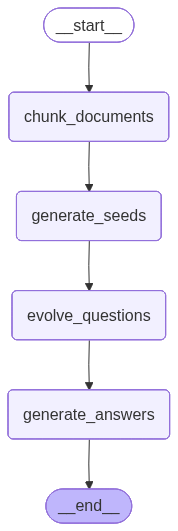

In [7]:
sdg_graph

In [8]:
# Load documents
loader = DirectoryLoader("data/", glob="*.txt", loader_cls=TextLoader)
docs = loader.load()
print(f"Loaded {len(docs)} documents")

# Invoke
result = sdg_graph.invoke({"documents": docs})

# Check the 3 required outputs
print(f"\n=== Results ===")
print(f"Evolved Questions: {len(result['evolved_questions'])}")
print(f"Answers: {len(result['answers'])}")
print(f"Contexts: {len(result['contexts'])}")



Loaded 2 documents
[chunk_documents] Created 21 chunks
  Seed 0: What are some factors that contribute to mental health?...
  Seed 1: What are the symptoms of Post-Traumatic Stress Disorder (PTSD)?...
  Seed 2: What hormone increases due to chronic stress and weakens the immune system?...
  Seed 3: What are the key components of Mindfulness-Based Stress Reduction (MBSR)?...
  Seed 4: What are the four key skill sets taught in Dialectical Behavior Therapy (DBT)?...
  Seed 5: What are the five components of emotional intelligence?...
  Seed 6: What are some types of therapeutic journaling mentioned in the passage?...
  Seed 7: What natural mood elevators are released during exercise?...
  Seed 8: What is the recommended first-line treatment for chronic insomnia?...
  Seed 9: What percentage lower risk of depression is associated with the Mediterranean di...
  Seed 10: What percentage of young people is affected by cyberbullying?...
  Seed 11: What is one strategy recommended for digital 

In [10]:
# Check the results

import pandas as pd

rows = []
ctx_by_id = {c["question_id"]: c for c in result["contexts"]}
ans_by_id = {a["question_id"]: a for a in result["answers"]}

for q in result["evolved_questions"]:
    c = ctx_by_id[q["id"]]
    a = ans_by_id[q["id"]]
    rows.append({
        "evolution_type": q["evolution_type"],
        "question": q["question"],
        "answer": a["answer"],
        "contexts": c["contexts"],
    })

df = pd.DataFrame(rows)
df

,evolution_type,question,answer,contexts
0,simple,What are some factors that contribute to menta...,Based on the provided context from The Mental ...,[The Mental Health and Psychology Handbook\nA ...
1,reasoning,What are some factors that contribute to menta...,Based on the provided context from *The Mental...,[The Mental Health and Psychology Handbook\nA ...
2,multi_context,What are some factors that contribute to menta...,Factors that contribute to mental health are m...,[The Mental Health and Psychology Handbook\nA ...
3,simple,What are the symptoms of Post-Traumatic Stress...,The symptoms of Post-Traumatic Stress Disorder...,[Types of anxiety disorders include:\n- Genera...
4,reasoning,What are the symptoms of Post-Traumatic Stress...,"Based on the provided context, the symptoms of...",[Types of anxiety disorders include:\n- Genera...
...,...,...,...,...
58,reasoning,"What are some signs of poor work-life balance,...","Signs of poor work-life balance, reflecting bo...",[PART 7: LIFESTYLE AND WELLNESS\n\nChapter 19:...
59,multi_context,What are some signs of poor work-life balance ...,Some signs of poor work-life balance closely r...,[PART 7: LIFESTYLE AND WELLNESS\n\nChapter 19:...
60,simple,What is the recommended room temperature for s...,The recommended room temperature for sleep acc...,[APPENDIX: QUICK REFERENCE GUIDES\n\nEmergency...
61,reasoning,What is the recommended room temperature for s...,The recommended room temperature for sleep acc...,[APPENDIX: QUICK REFERENCE GUIDES\n\nEmergency...


In [13]:
pd.set_option('display.max_colwidth', None)
df[["evolution_type", "question", "answer"]].head(9)

,evolution_type,question,answer
0,simple,What are some factors that contribute to mental health?,"Based on the provided context from The Mental Health and Psychology Handbook, several factors contribute to mental health. These include:\n\n1. **Biological Factors**: Genetics, brain chemistry, and hormones play an important role in influencing mental health.\n\n2. **Life Experiences**: Events such as trauma, abuse, or significant life changes can impact an individual's mental well-being.\n\n3. **Family History**: The presence of mental health conditions in close relatives may affect one’s mental health.\n\n4. **Social Environment**: Relationships, community connections, and support systems are crucial contributors to mental health.\n\n5. **Physical Health**: Factors such as chronic illnesses, sleep quality, and nutrition influence mental well-being.\n\n6. **Lifestyle Choices**: Habits related to exercise, substance use, and stress management also affect mental health.\n\nThese factors interact to shape an individual’s unique experience of mental health across the spectrum."
1,reasoning,"What are some factors that contribute to mental health, and how might their effects vary depending on individual socioeconomic backgrounds?","Based on the provided context from *The Mental Health and Psychology Handbook*, several factors contribute to mental health. These include biological factors (such as genetics, brain chemistry, and hormones), life experiences (including trauma, abuse, or significant life changes), family history (presence of mental health conditions in close relatives), social environment (relationships, community, and support systems), physical health (conditions like chronic illness, sleep quality, and nutrition), and lifestyle choices (exercise habits, substance use, and stress management).\n\nThe effects of these factors can vary significantly depending on an individual's socioeconomic background. For example, someone from a lower socioeconomic status may experience more frequent or intense life stressors such as financial instability, limited access to quality healthcare, or unsafe living environments. These conditions can exacerbate life experiences like trauma or abuse and negatively impact the social environment by limiting supportive community connections. Additionally, lower socioeconomic status can affect physical health through reduced access to nutritious food, safe places to exercise, or adequate sleep conditions, influencing overall mental well-being.\n\nConversely, individuals from higher socioeconomic backgrounds might have more resources and support systems in place, such as better healthcare access, more stable social networks, and greater opportunities for stress management through education or leisure activities. However, they are not immune to biological or family-related factors that contribute to mental health challenges.\n\nIn summary, while the contributing factors to mental health are consistent across populations, socioeconomic background influences both the exposure to risk factors and the availability of protective resources, resulting in varied effects on mental well-being from person to person."
2,multi_context,"What are some factors that contribute to mental health, and how do daily habits like morning and evening routines influence these factors?","Factors that contribute to mental health are multifaceted and include biological, psychological, and social elements. According to *The Mental Health and Psychology Handbook*, the key factors influencing mental health are:\n\n- **Biological factors:** such as genetics, brain chemistry, and hormones, which can affect emotional regulation and psychological well-being.\n- **Life experiences:** including trauma, abuse, or significant life changes that impact mental resilience and coping abilities.\n- **Family history:** the presence of mental health conditions in close relatives, potentially increasing vulnerability.\n- **Social environment:** qualit